# Lista 07 - Comparando Classificadores

# Exercício 01:

Analise o desempenho do kNN e de uma Regressão Logística Regularizada para **pelo menos um** dos conjuntos de dados abaixo:

* [Avaliação de carros](http://archive.ics.uci.edu/ml/datasets/Car+Evaluation)
* [Avaliação de vinhos](http://archive.ics.uci.edu/ml/datasets/Wine+Quality)
* [Resultados de partidas do jogo Dota](http://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results) (desafiador!)

Para a questão, faça as seguintes tarefas:

* Realize treino, validação e teste
* Compare as métricas no teste
* Reporte a precisão, revocação, F1 e a matriz de confusão

Como já estamos no fim da matéria, você pode agora fazer uso da biblioteca scikit-learn. Afinal, no dia a dia, não implementamos tudo do zero. Abaixo temos os imports que vocês precisam. Leiam a API da biblioteca para saber como fazer uso da mesma.

In [59]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn.neighbors import KNeighborsClassifier

# Um fator importante é que o SKLearn não cria conjuntos de validação para você. Você tem algumas abordagens,
# uma é realizar um novo split no treino. Outra é fazer uso de classificadores com CV no fim.
# Tipo LogisticRegressionCV (ver na API). Por fim, você pode fazer uso da classe GridSearchCV.
# Leia a documentação da mesma.
from sklearn.model_selection import train_test_split

### Car Data

Escolhi a base de dados de avaliação de carros

In [60]:
#Primeiramente, ler os dados
import pandas as pd
df = pd.read_csv("data.csv")
df.head()


,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [61]:
#adicionando nomes para colunas para facilitar a indexacao dos dados
df.columns = ["buying","maint","doors","persons","lug_boot","safety","class"]
#Como a ultima coluna nao apresenta features (acho que eh lixo), a iremos remover
df["ID"] = df.index
df.head()


,buying,maint,doors,persons,lug_boot,safety,class,ID
0,vhigh,vhigh,2,2,small,med,unacc,0
1,vhigh,vhigh,2,2,small,high,unacc,1
2,vhigh,vhigh,2,2,med,low,unacc,2
3,vhigh,vhigh,2,2,med,med,unacc,3
4,vhigh,vhigh,2,2,med,high,unacc,4


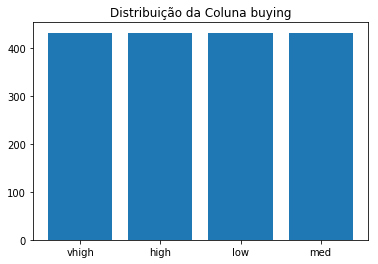

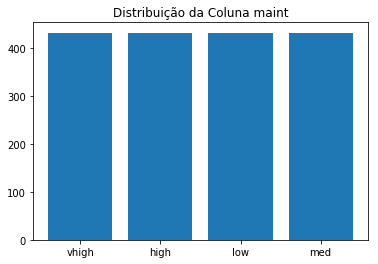

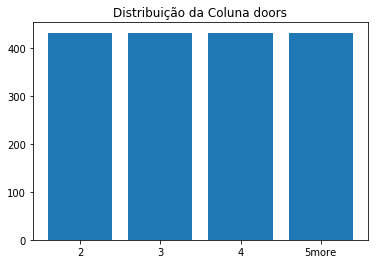

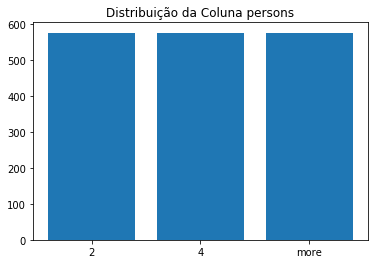

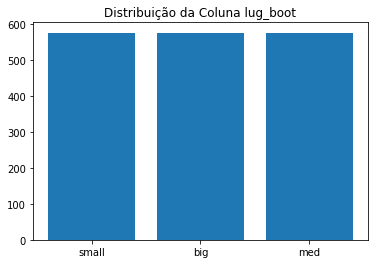

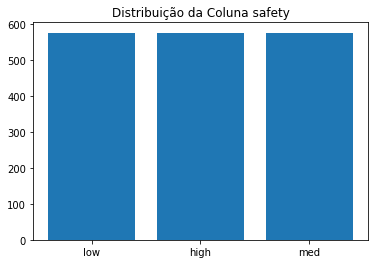

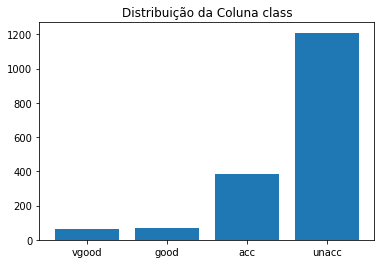

In [62]:
# Agora, iremos plotar graficos para representar as distribuicoes dos dados
import matplotlib.pyplot as plt
def plot_dist(data,label,title, threshold=None):
    data[label].unique()
    aux = data[[label,'ID']]
    aux = aux.groupby([label]).count()
    if(threshold):
        aux = aux[aux["ID"]>threshold]
    
    aux = aux.sort_values('ID')
    
    plt.title(title)
    plt.bar(aux.index,aux["ID"])
    plt.show()

    
for col in df.columns:
    if(col!="ID"):
        plot_dist(df,col,"Distribuição da Coluna "+str(col))


Como é possivel observar, todas as features são categóricas. Além disso, temos 4 classes possíveis.
Agora, iremos alterar as features para representação one-hot

In [63]:
FEATURES = ["buying","maint","doors","persons","lug_boot","safety"]
TARGET = ["class"]

tgt = df[TARGET]
df = df.drop(["class","ID"],axis=1)
df = pd.get_dummies(df, columns=FEATURES)
tgt = pd.get_dummies(tgt)
df.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0


In [76]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(df, tgt, test_size=0.33, random_state=42)
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train) # treina no conjunto de treino

y = model.predict(X_test) # previsões no conjunto de validação        
# Resultado com melhor acurácia!
accuracy = accuracy_score(y, y_test)
print(accuracy)
# y_pv = model.predict(X_) # previsões no conjunto de validação

0.856140350877193


Explique e discuta sobre os resultados encontrados no campo abaixo.

YOUR ANSWER HERE